In [5]:
"""
Inter-Chain C-C, C-G, and G-G Contact Enrichment Analysis Script for Submission

Author: Qin Zhang
Created: 2025-06-11
Last Modified: 2025-06-11
License: MIT License

This script analyzes inter-chain C-C, C-G, and G-G contact enrichments in RNA systems under varying 
salt concentrations.
"""

# %% Part 1: Data Generation
import MDAnalysis as mda
import numpy as np
import pickle
import matplotlib.pyplot as plt
from MDAnalysis.analysis import distances
import os
from tqdm import tqdm
"""
Define file paths for RNA systems (3xG4C2 and 5xG4C2) under different salt conditions.
Data source: Zenodo repository (DOI: 10.5281/zenodo.15608685)
"""
conditions_3x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_5x ={
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
"""
Define chain index ranges for 5xG4C2 system.
Each chain is represented as a slice object for atom selection.
"""
chains_5x = {
    "ch1": slice(0, 359),
    "ch2": slice(360, 719),
    "ch3": slice(720, 1079),
    "ch4": slice(1080, 1439),
    "ch5": slice(1440, 1799),
    "ch6": slice(1800, 2159),
    "ch7": slice(2160, 2519),
    "ch8": slice(2520, 2879),
    "ch9": slice(2880, 3239),
    "ch10": slice(3240, 3599),
    "ch11": slice(3600, 3959),
    "ch12": slice(3960, 4319)
}
# System configuration dictionary
SYSTEMS = {
    '3xG4C2': {
        'chains': {f"ch{i}": slice(i*216, (i+1)*216) for i in range(12)},  # Adjust according to actual situation
        'conditions': conditions_3x,
        'color': {'CC': '#1f77b4', 'CG': '#ff7f0e', 'GG': '#2ca02c'}
    },
    '5xG4C2': {
        'chains': chains_5x,
        'conditions': conditions_5x,
        'color': {'CC': '#aec7e8', 'CG': '#ffbb78', 'GG': '#98df8a'}
    }
}

# Experimental parameters
SALT_CONCENTRATIONS = [0, 17, 35, 70, 139, 278, 487, 696]  # mM NaCl
REPLICAS = ['C1', 'C2', 'C3', 'C4'] # Simulation replicas
CONTACT_TYPES = ['CC', 'CG', 'GG']   # Contact types (C-C, C-G, G-G)

# ================== Analysis Function ==================
def analyze_system(system_name, system_config, condition_name, condition_path, verbose=True):
    """
    Analyze inter-chain contact enrichments for a specific system and condition.
    
    Parameters:
        system_name (str): System identifier (e.g., '3xG4C2')
        system_config (dict): System configuration (chains, colors, etc.)
        condition_name (str): Condition name (e.g., '487mMNaCl')
        condition_path (str): Path to simulation data
        verbose (bool): If True, print detailed analysis progress
        
    Returns:
        dict: Global mean and standard deviation of contact enrichments
    """
    replica_means = {ct: [] for ct in CONTACT_TYPES}  # Store replica-level means
    frame_counts = {replica: 0 for replica in REPLICAS}  # Track valid frames
    atom_counts = {}                                    # Store atom counts    

    if verbose:
        print(f"\n{'='*80}")
        print(f"Analysis for {system_name} - {condition_name}")
        print(f"{'='*80}")
    
    for replica in REPLICAS:
        gro_path = os.path.join(condition_path, replica, "RNA.gro")
        xtc_path = os.path.join(condition_path, replica, "RNA_clusterRNA.xtc")
        
        if not (os.path.exists(gro_path) and os.path.exists(xtc_path)):
            if verbose:
                print(f"⚠️  Replica {replica} data missing. Skipping...")
            continue
            
        u = mda.Universe(gro_path, xtc_path)
        results = {ct: [] for ct in CONTACT_TYPES} # Store frame-level results
        
        # Prepare chain data with C and G residue selections
        chains = {}
        for chain_name, slc in system_config['chains'].items():
            chain = u.atoms[slc]
            C = chain.select_atoms("resname RC and name SC3") # C residue SC3 atoms
            G = chain.select_atoms("resname RG and name SC3") # G residue SC3 atoms
            chains[chain_name] = {"C": C, "G": G}
        
        # Store atom counts for printing (only for first replica)
        if replica == 'C1' and system_name not in atom_counts:
            atom_counts[system_name] = {
                'C': sum(len(chain["C"]) for chain in chains.values()),
                'G': sum(len(chain["G"]) for chain in chains.values())
            }
        
        # Calculate theoretical contact ratios (combinatorial)
        c_counts = [len(chain["C"]) for chain in chains.values()]
        g_counts = [len(chain["G"]) for chain in chains.values()]
        
        total_c = np.sum(c_counts)
        total_g = np.sum(g_counts)
        sum_c_sq = np.sum(np.square(c_counts))
        sum_g_sq = np.sum(np.square(g_counts))
        sum_cg = np.sum([c*g for c,g in zip(c_counts,g_counts)])
        
        theory_CC = (total_c**2 - sum_c_sq)/2  # Inter-chain C-C contacts
        theory_CG = total_c*total_g - sum_cg # Inter-chain C-G contacts
        theory_GG = (total_g**2 - sum_g_sq)/2 # Inter-chain G-G contacts
        total_theory = theory_CC + theory_CG + theory_GG
        theory_ratios = {
            "CC": theory_CC/total_theory,
            "CG": theory_CG/total_theory,
            "GG": theory_GG/total_theory
        }
        
        # Trajectory analysis (inter-chain contacts < 6/9Å)
        valid_frames = 0
        for ts in u.trajectory[::50]:  # Analyze every 50 frames
            actual_CC, actual_CG, actual_GG = 0, 0, 0
            chain_list = list(chains.values())
            
            # Calculate inter-chain contacts
            for i in range(len(chain_list)):
                for j in range(i+1, len(chain_list)):
                    # C-C contacts
                    ci = chain_list[i]["C"].positions
                    cj = chain_list[j]["C"].positions
                    if len(ci)*len(cj) > 0:
                        dist = distances.distance_array(ci, cj, box=ts.dimensions)
                        actual_CC += np.sum(dist < 6)  ## please change dist < 9 to have figure3b in manuscript
                    
                    # C-G contacts
                    ci = chain_list[i]["C"].positions
                    gj = chain_list[j]["G"].positions
                    if len(ci)*len(gj) > 0:
                        dist = distances.distance_array(ci, gj, box=ts.dimensions)
                        actual_CG += np.sum(dist < 6) ## please change dist < 9 to have figure3b in manuscript

                    # G-G contacts
                    gi = chain_list[i]["G"].positions
                    gj = chain_list[j]["G"].positions
                    if len(gi)*len(gj) > 0:
                        dist = distances.distance_array(gi, gj, box=ts.dimensions)
                        actual_GG += np.sum(dist < 6) ## please change dist < 9 to have figure3b in manuscript
            
            total = actual_CC + actual_CG + actual_GG

            if total > 0:
                valid_frames += 1
                # Calculate enrichment/depletion relative to theory
                for ct, val in zip(CONTACT_TYPES, [actual_CC, actual_CG, actual_GG]):
                    results[ct].append(val/total - theory_ratios[ct])
            else:
                for ct in CONTACT_TYPES:
                    results[ct].append(np.nan)
        
        frame_counts[replica] = valid_frames# Store valid frame count
        
        # Calculate replica mean (only for valid data)
        replica_stats = {}
        for ct in CONTACT_TYPES:
            clean_data = np.array(results[ct])
            clean_data = clean_data[~np.isnan(clean_data)]
            if len(clean_data) > 0:
                replica_mean = np.mean(clean_data)
                replica_means[ct].append(replica_mean)
                replica_stats[ct] = replica_mean
            else:
                replica_stats[ct] = np.nan
        
        # Print replica details
        if verbose and valid_frames > 0:
            print(f"\nReplica {replica}: {valid_frames} valid frames")
            for ct in CONTACT_TYPES:
                print(f"  {ct} mean: {replica_stats[ct]:.4f}")
        elif verbose:
            print(f"\n⚠️  Replica {replica} has NO valid frames (all frames had 0 contacts)")
    
    # Print atom counts (once per system)
    if verbose and atom_counts:
        sys_atoms = atom_counts.get(system_name, {'C': 0, 'G': 0})
        print(f"\nAtom counts for {system_name}: C atoms={sys_atoms['C']}, G atoms={sys_atoms['G']}")
    
    # Calculate global statistics with SD (replica-level)
    global_stats = {}
    for ct in CONTACT_TYPES:
        means = np.array(replica_means[ct])
        valid_means = means[~np.isnan(means)]
        n_replicas = len(valid_means)
        
        if n_replicas == 0:
            global_mean = 0.0
            sd = 0.0
            if verbose:
                print(f"\n⚠️  {ct}: No valid replicas found. Setting mean and SD to 0")
        else:
            # Calculate global mean as average of replica means
            global_mean = np.mean(valid_means)
            
            if n_replicas > 1:
                deviations = valid_means - global_mean
                sum_sq_deviations = np.sum(deviations**2)
                # SD with Bessel's correction (n-1)
                sd = np.sqrt(sum_sq_deviations / (n_replicas - 1))
            else:
                sd = 0.0  # Not enough replicas to calculate SD
        
        global_stats[ct] = (global_mean, sd)
        
        # Print detailed SD calculation
        if verbose and n_replicas > 0:
            print(f"\n{ct} Statistics:")
            print(f"  Replica means: {', '.join([f'{m:.4f}' for m in valid_means])}")
            print(f"  Global mean: {global_mean:.4f}")
            if n_replicas > 1:
                print(f"  Deviations: {', '.join([f'{(m - global_mean):.4f}' for m in valid_means])}")
                print(f"  Squared deviations: {', '.join([f'{(d**2):.4f}' for d in (valid_means - global_mean)])}")
                print(f"  Sum of squared deviations: {sum_sq_deviations:.4f}")
                print(f"  SD (n-1): {sd:.4f} (based on {n_replicas} replicas)")
            else:
                print(f"  ⚠️  Only 1 valid replica - SD set to 0")
    
    return global_stats

# Execute analysis for all systems and conditions
full_results = {}
for system_name in SYSTEMS:
    full_results[system_name] = {}
    for cond_name, cond_path in SYSTEMS[system_name]['conditions'].items():
        salt = int(cond_name.replace('mMNaCl', '')) if 'mMNaCl' in cond_name else 0
        full_results[system_name][salt] = analyze_system(
            system_name, 
            SYSTEMS[system_name], 
            cond_name, 
            cond_path,
            verbose=True  # Enable detailed printing
        )

with open('35_inter_chain_enrichment.pkl', 'wb') as f:
    pickle.dump(full_results, f)


Analysis for 3xG4C2 - neutral

Replica C1: 201 valid frames
  CC mean: -0.0162
  CG mean: -0.1568
  GG mean: 0.1730

Replica C2: 201 valid frames
  CC mean: -0.0317
  CG mean: -0.0565
  GG mean: 0.0883

Replica C3: 201 valid frames
  CC mean: 0.0867
  CG mean: -0.2646
  GG mean: 0.1779

Replica C4: 201 valid frames
  CC mean: -0.0600
  CG mean: -0.1792
  GG mean: 0.2392

Atom counts for 3xG4C2: C atoms=72, G atoms=144

CC Statistics:
  Replica means: -0.0162, -0.0317, 0.0867, -0.0600
  Global mean: -0.0053
  Deviations: -0.0109, -0.0264, 0.0920, -0.0547
  Squared deviations: 0.0001, 0.0007, 0.0085, 0.0030
  Sum of squared deviations: 0.0123
  SD (n-1): 0.0640 (based on 4 replicas)

CG Statistics:
  Replica means: -0.1568, -0.0565, -0.2646, -0.1792
  Global mean: -0.1643
  Deviations: 0.0075, 0.1078, -0.1003, -0.0149
  Squared deviations: 0.0001, 0.0116, 0.0101, 0.0002
  Sum of squared deviations: 0.0220
  SD (n-1): 0.0855 (based on 4 replicas)

GG Statistics:
  Replica means: 0.1730, 

In [7]:
# %% Part 2: Data Loading and Plotting
import pickle
import numpy as np

# Load precomputed inter-chain contact enrichment results
with open('35_inter_chain_enrichment.pkl', 'rb') as f:
    full_results = pickle.load(f)
    
# Define parameters for plotting
salt_order = [0, 17, 35, 70, 139, 278, 487, 696]
systems = ['3xG4C2', '5xG4C2']
ctypes = ['CC', 'CG', 'GG']

# Organize data into numpy array: [salt, system, ctype, (mean, sd)]
plot_data = np.zeros((len(salt_order), len(systems), len(ctypes), 2))
for i, salt in enumerate(salt_order):
    for j, sys in enumerate(systems):
        for k, ct in enumerate(ctypes):
            plot_data[i,j,k] = full_results[sys][salt][ct]

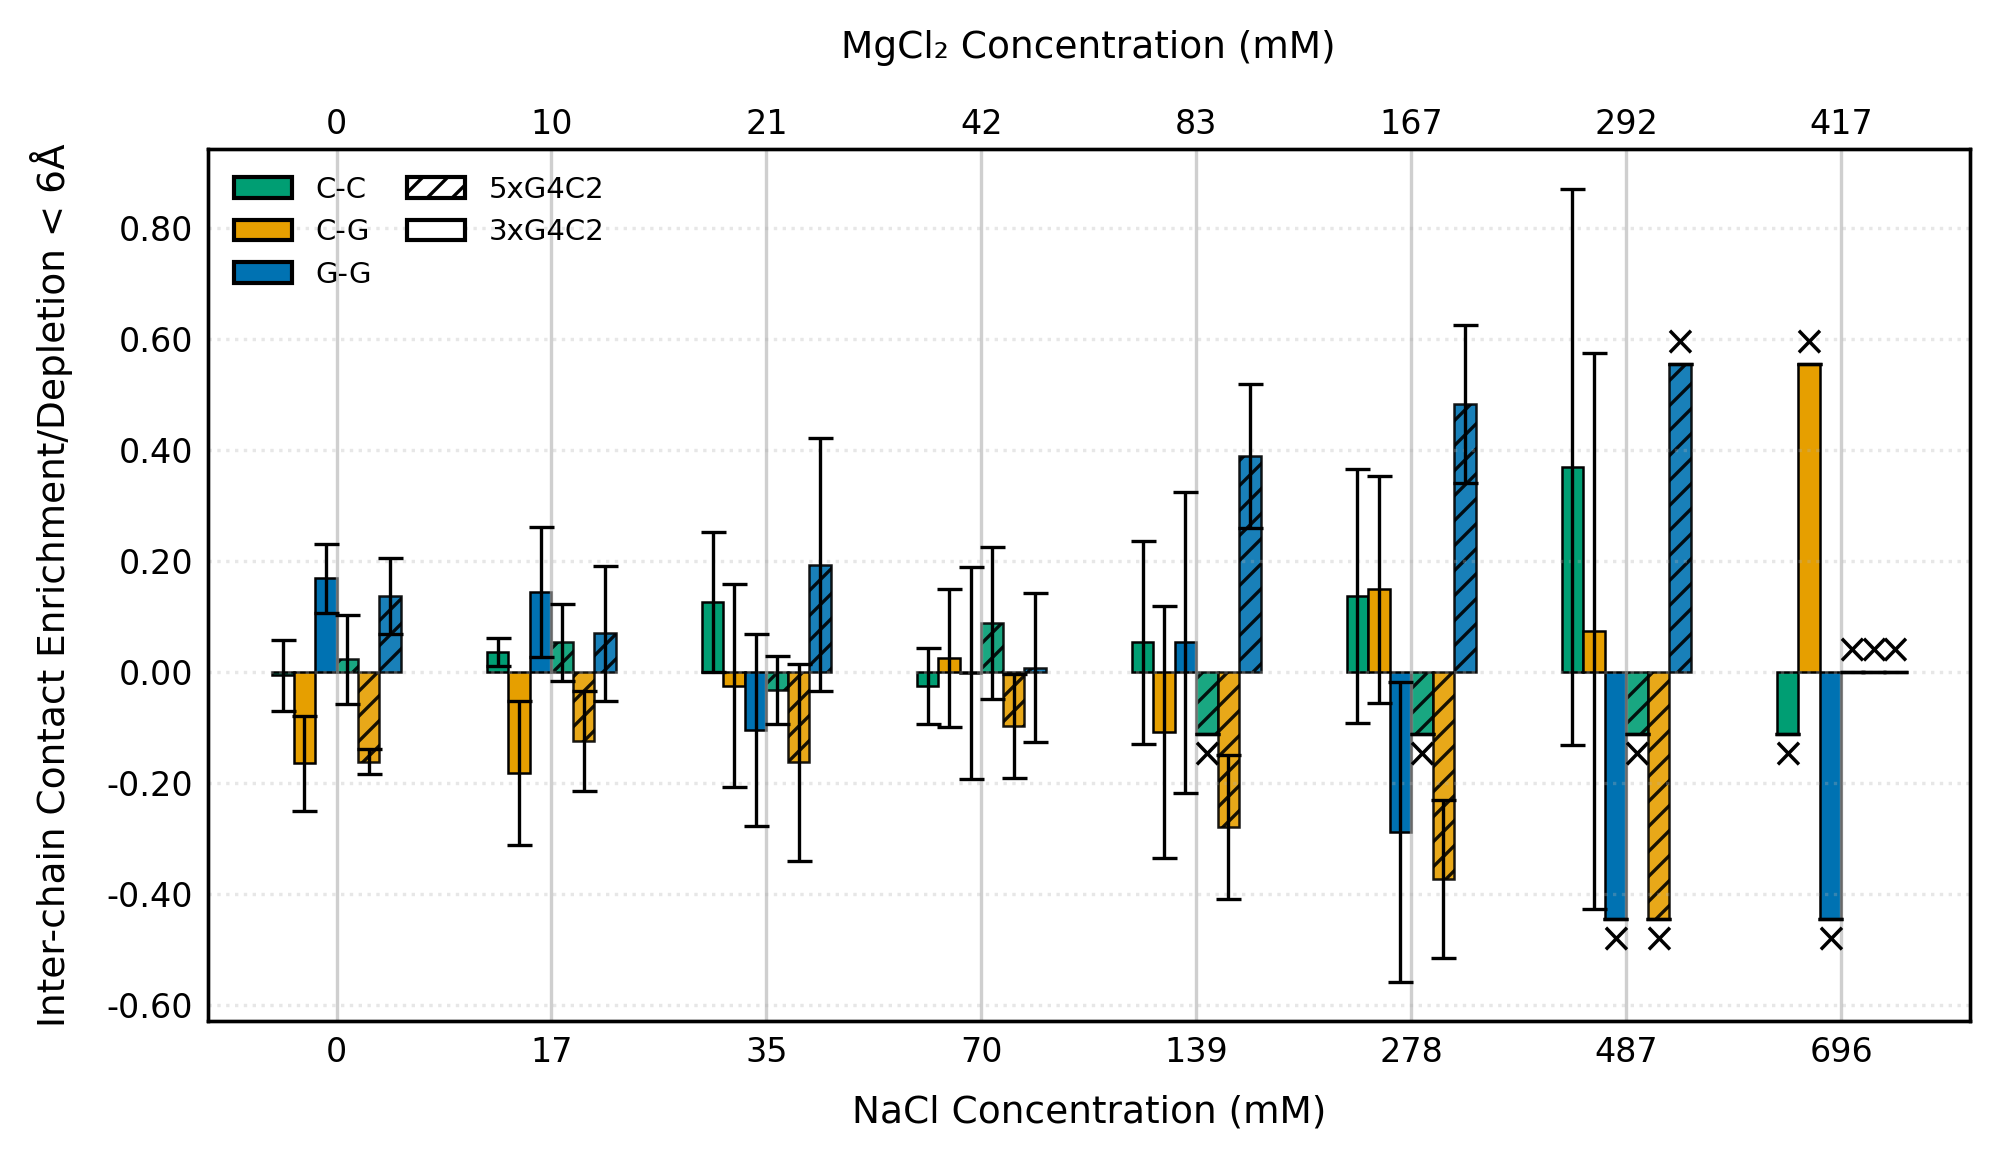

In [8]:
# %% Cell 3: Generate Publication-Quality Plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams

rcParams.update({
    'font.sans-serif': 'DejaVu Sans', 
    'font.size': 8,            
    'axes.linewidth': 0.8,      
    'xtick.major.width': 0.8,    
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,   
    'ytick.minor.width': 0.6,
    'axes.labelsize': 9,         
    'axes.titlesize': 9,        
    'legend.fontsize': 7,       
    'figure.dpi': 300,          
    'figure.figsize': (6.8, 4.0),  
    'savefig.dpi': 300,         
    'hatch.linewidth': 0.8       
})
# Color mapping for contact types (color-blind friendly)
COLOR_MAP = {
    'CC': '#009E73',  # Green
    'CG': '#E69F00',  # Orange
    'GG': '#0072B2'   # Blue
}

fig, ax = plt.subplots()
nacl_ticks = np.array([0, 17, 35, 70, 139, 278, 487, 696])
mgcl2_ticks = np.array([0, 10, 21, 42, 83, 167, 292, 417]) # NaCl to MgCl2 conversion
x_pos = np.arange(len(nacl_ticks))
bar_width = 0.1 
offset_dict = {
    '3xCC': -bar_width*2.5,
    '3xCG': -bar_width*1.5,
    '3xGG': -bar_width*0.5,
    '5xCC': bar_width*0.5,
    '5xCG': bar_width*1.5,
    '5xGG': bar_width*2.5
}# Offset for grouped bars

# Main plotting logic with SD handling
for sidx in range(len(nacl_ticks)):
    # Plot 3xG4C2 system (solid bars)
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        offset = list(offset_dict.values())[i]
        mean, sd = plot_data[sidx, 0, i]
        
        # Handle cases where SD is zero (add "×" marker)
        if abs(sd) < 1e-5:  # Floating point tolerance
            # Plot bar without error bar
            ax.bar(x_pos[sidx] + offset, mean, bar_width,
                   color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
                   yerr=0, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})
            # Position marker based on value sign
            if mean >= 0:
                ax.text(x_pos[sidx] + offset, mean, "×", 
                        ha='center', va='bottom', color='black', fontsize=10)
            else:
                ax.text(x_pos[sidx] + offset, mean, "×", 
                        ha='center', va='top', color='black', fontsize=10)
        else:
            ax.bar(x_pos[sidx] + offset, mean, bar_width,
                   color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
                   yerr=sd,error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})
    
    # Plot 5xG4C2 system (hatched bars)
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        offset = list(offset_dict.values())[i+3]
        mean, sd = plot_data[sidx, 1, i]
        
        if abs(sd) < 1e-5: 
            ax.bar(x_pos[sidx] + offset, mean, bar_width,
                   color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
                   hatch='////', alpha=0.9,
                   yerr=0, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})
            
            # Position symbol based on value sign
            if mean >= 0:
                ax.text(x_pos[sidx] + offset, mean, "×", 
                        ha='center', va='bottom', color='black', fontsize=10)
            else:
                ax.text(x_pos[sidx] + offset, mean, "×", 
                        ha='center', va='top', color='black', fontsize=10)
        else:
            ax.bar(x_pos[sidx] + offset, mean, bar_width,
                   color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
                   hatch='////', alpha=0.9,
                   yerr=sd, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})

# Configure axes and labels
ax.set_xlabel('NaCl Concentration (mM)', labelpad=6)
ax.set_xlim(-0.6, len(nacl_ticks)-0.4)
ax.set_xticks(x_pos)
ax.set_xticklabels(nacl_ticks, rotation=0, ha='center') 
ax.tick_params(axis='x', which='both',length=0, bottom=False)  

# Secondary x-axis for MgCl2 concentration
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x_pos)
ax_top.set_xticklabels(mgcl2_ticks, rotation=0, ha='center', va='bottom')  
ax_top.set_xlabel('MgCl₂ Concentration (mM)', labelpad=12)
ax_top.tick_params(axis='x', length=0,   pad=2)    

ax.set_ylabel('Inter-chain Contact Enrichment/Depletion < 6Å', labelpad=8)
# ax.set_ylim(-0.6, 0.8)

# ax.yaxis.set_major_locator(MultipleLocator(0.03))
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax.set_xticks(x_pos)
ax.tick_params(axis='both', which='major', length=0, width=0.8)  

legend_elements = [
    Patch(facecolor=COLOR_MAP['CC'], edgecolor='k', label='C-C'),
    Patch(facecolor=COLOR_MAP['CG'], edgecolor='k', label='C-G'),
    Patch(facecolor=COLOR_MAP['GG'], edgecolor='k', label='G-G'),
    Patch(facecolor='white', edgecolor='k', hatch='////', label='5xG4C2'),
    Patch(facecolor='white', edgecolor='k', label='3xG4C2'),
    # plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=9, 
    #                label='SD=0 (no vaild replicas)')
]

ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.6)
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.8, alpha=0.3)
ax.legend(handles=legend_elements, 
         loc='upper left', 
         ncol=2,
         frameon=False,
         handletextpad=0.8,
         columnspacing=1.2)

plt.tight_layout(pad=1.5)
plt.savefig('figure3b_figS3b.png',dpi=300, format='png')
plt.show()